# Analyzing the result of the model error experiment

In [84]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper

path = '../../dgym-data/analysis/noise/noise-2024-04-17_17-49-55.zip'

records = []
with zipfile.ZipFile(path, 'r') as z:
    for filename in tqdm(z.namelist()):
        if filename.endswith('.json'):
            with z.open(filename) as file:
                with TextIOWrapper(file, encoding='utf-8') as text_file:
                    try:
                        result = json.load(text_file)
                        record = {'sigma': result['sigma'], 'cost': result['cost'], 'outcome': result.get('outcome', 0)}
                        records.append(record)
                        result = None
                    except:
                        continue

df = pd.DataFrame(records)
records = None

  0%|          | 0/4200 [00:00<?, ?it/s]

(-0.05, 1.05)

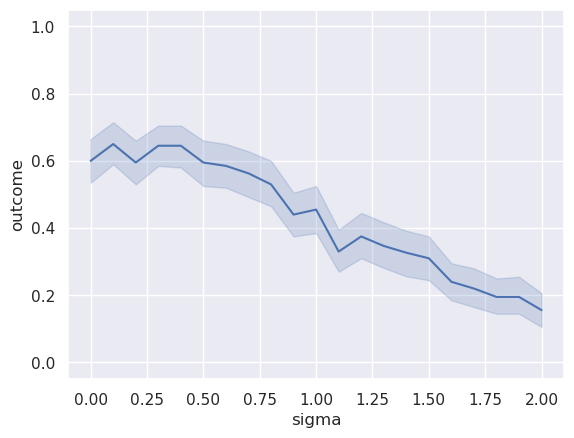

In [85]:
import seaborn as sns

sns.set()
sns.lineplot(df, x='sigma', y='outcome')

plt.ylim(-0.05, 1.05)

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
max_cost = df['cost'].max()
timeline = np.linspace(0, max_cost, 3_000)

ecdfs = []
for idx, (sigma, group) in enumerate(df.groupby('sigma')):
    
    # if idx % 4 == 0:

    # Create Kaplan-Meier object
    kmf = KaplanMeierFitter()

    # Fit data
    kmf.fit(durations=group['cost'], event_observed=group['outcome'], timeline=timeline)
    ecdf_ = pd.merge(
        kmf.cumulative_density_,
        right=kmf.confidence_interval_cumulative_density_,
        left_index=True,
        right_index=True
    ).reset_index()
    ecdf_['sigma'] = sigma
    ecdfs.append(ecdf_)

ecdf = pd.concat(ecdfs)

Text(0.5, 1.0, 'Cumulative probability of success versus model error ($\\sigma$)')

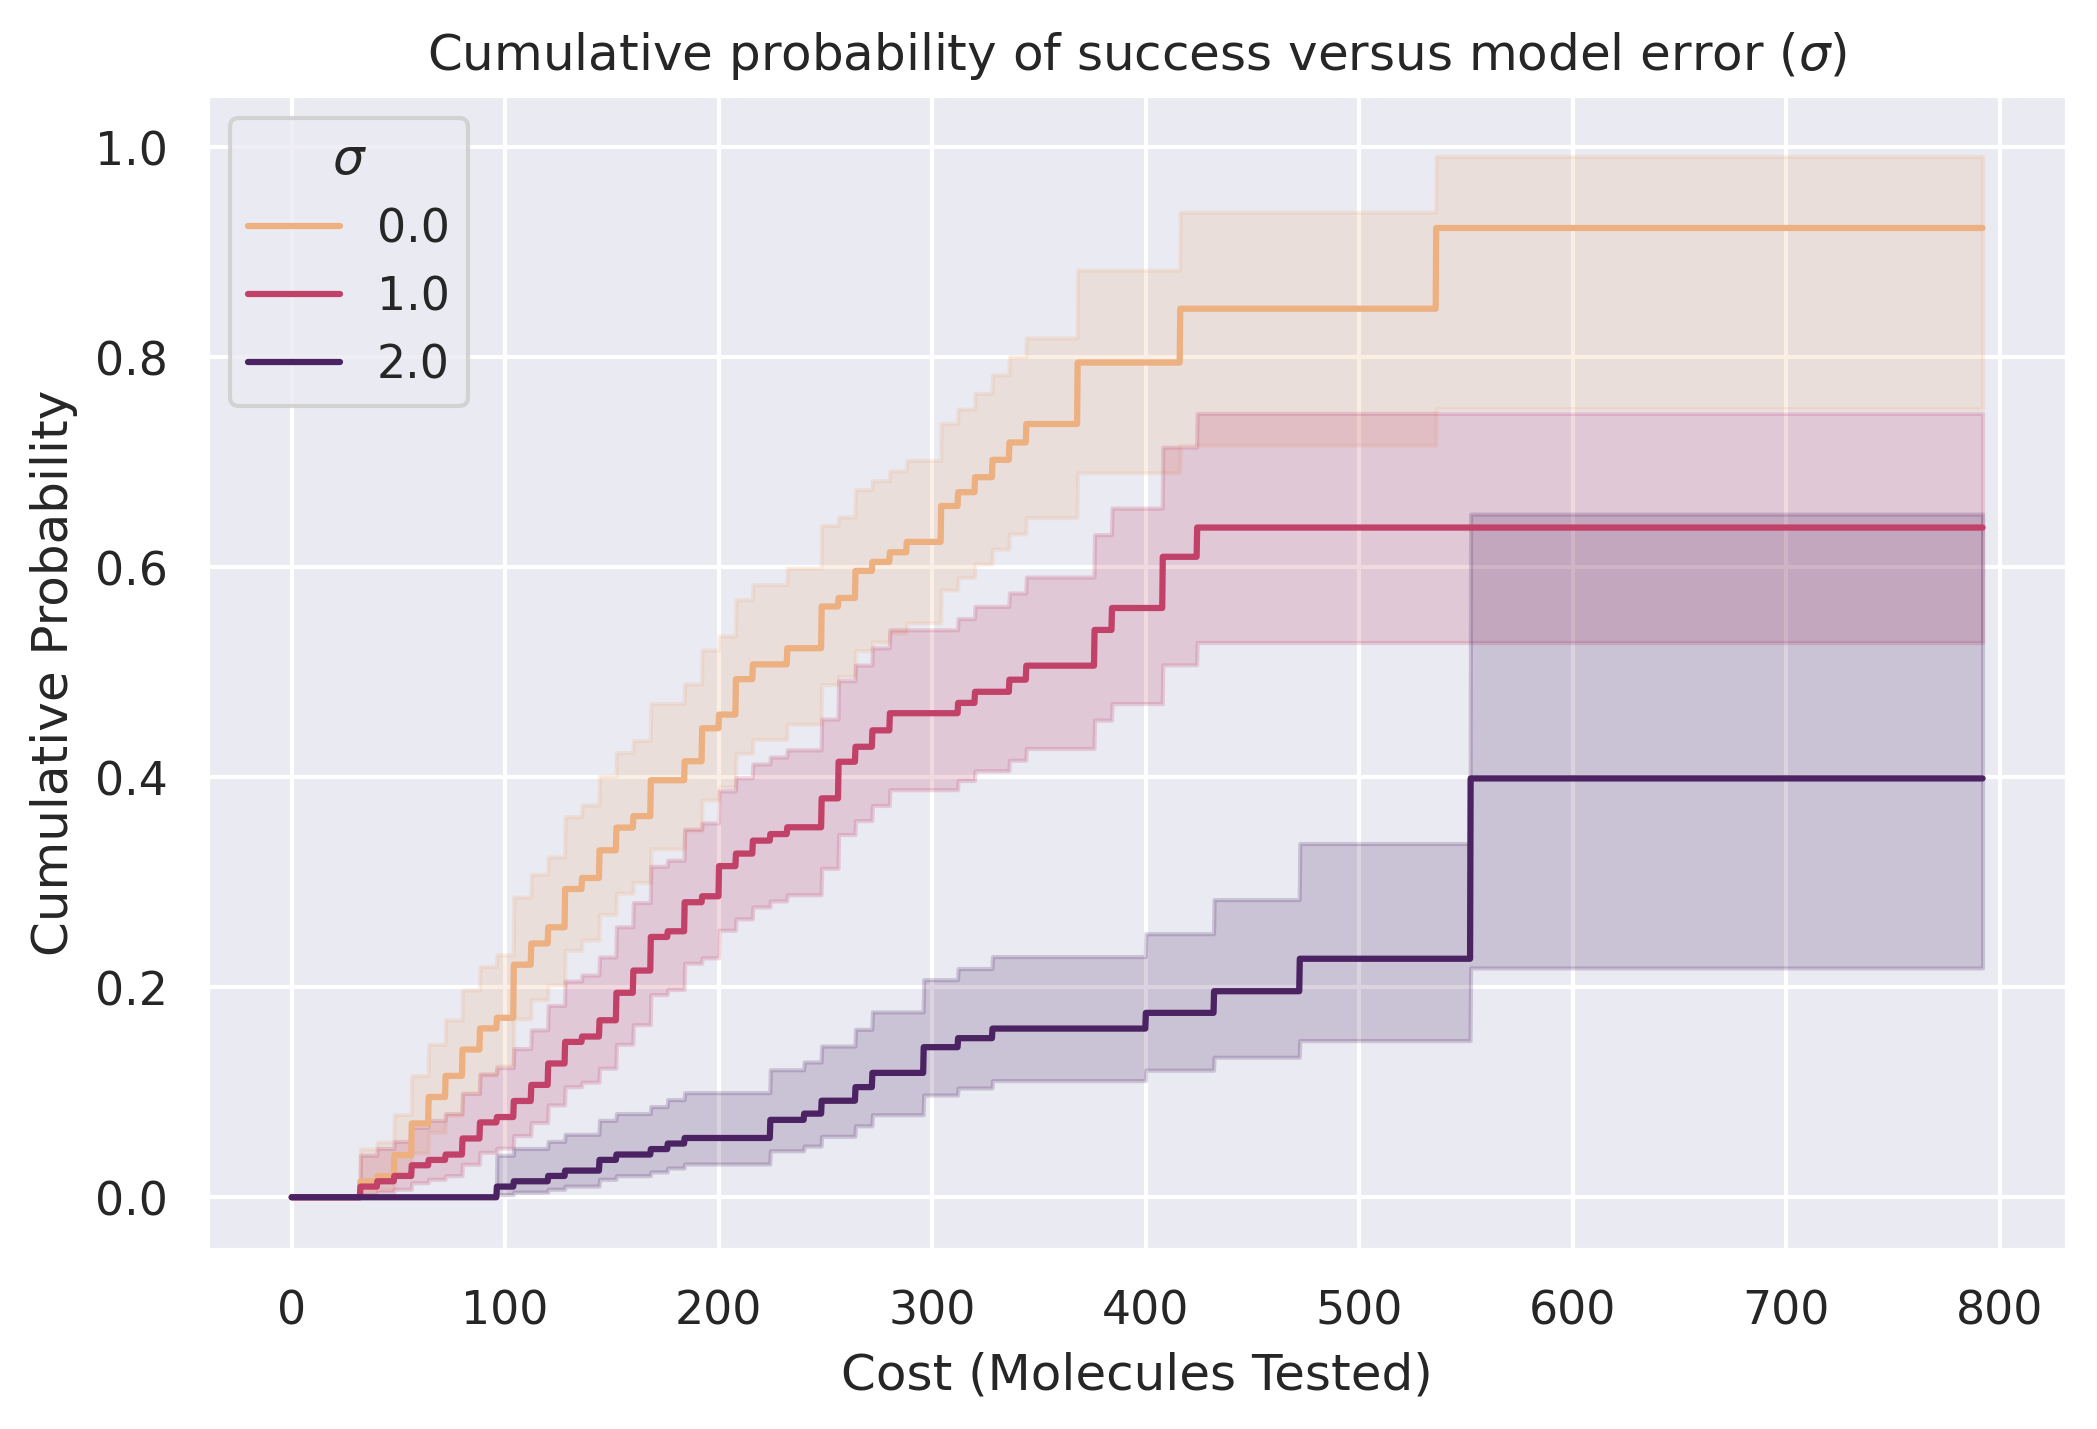

In [146]:
plt.figure(figsize=(8, 5), dpi=300)

interval = 1.0

g = sns.lineplot(
    ecdf.query(f'sigma % {interval} == 0'),
    x='timeline',
    y='KM_estimate',
    hue='sigma',
    palette='flare'
)

colormap = sns.palettes.get_colormap('flare')
colors = colormap.resampled(len(ecdf.query(f'sigma % {interval} == 0').groupby('sigma')))

for idx, (name, group) in enumerate(ecdf.query(f'sigma % {interval} == 0').groupby('sigma')):
    g.fill_between(
        group['timeline'],
        group['KM_estimate_lower_0.95'],
        group['KM_estimate_upper_0.95'],
        alpha=0.2,
        color=colors.colors[idx]
    )

plt.legend(title='$\sigma$')
plt.xlabel('Cost (Molecules Tested)')
plt.ylabel('Cumulative Probability')
plt.ylim(-0.05, 1.05)
plt.title('Cumulative probability of success versus model error ($\sigma$)')

Plot a single line.

Text(0.5, 1.0, 'Cumulative prob. of success versus model error ($\\sigma$) | Budget = 200 molecules')

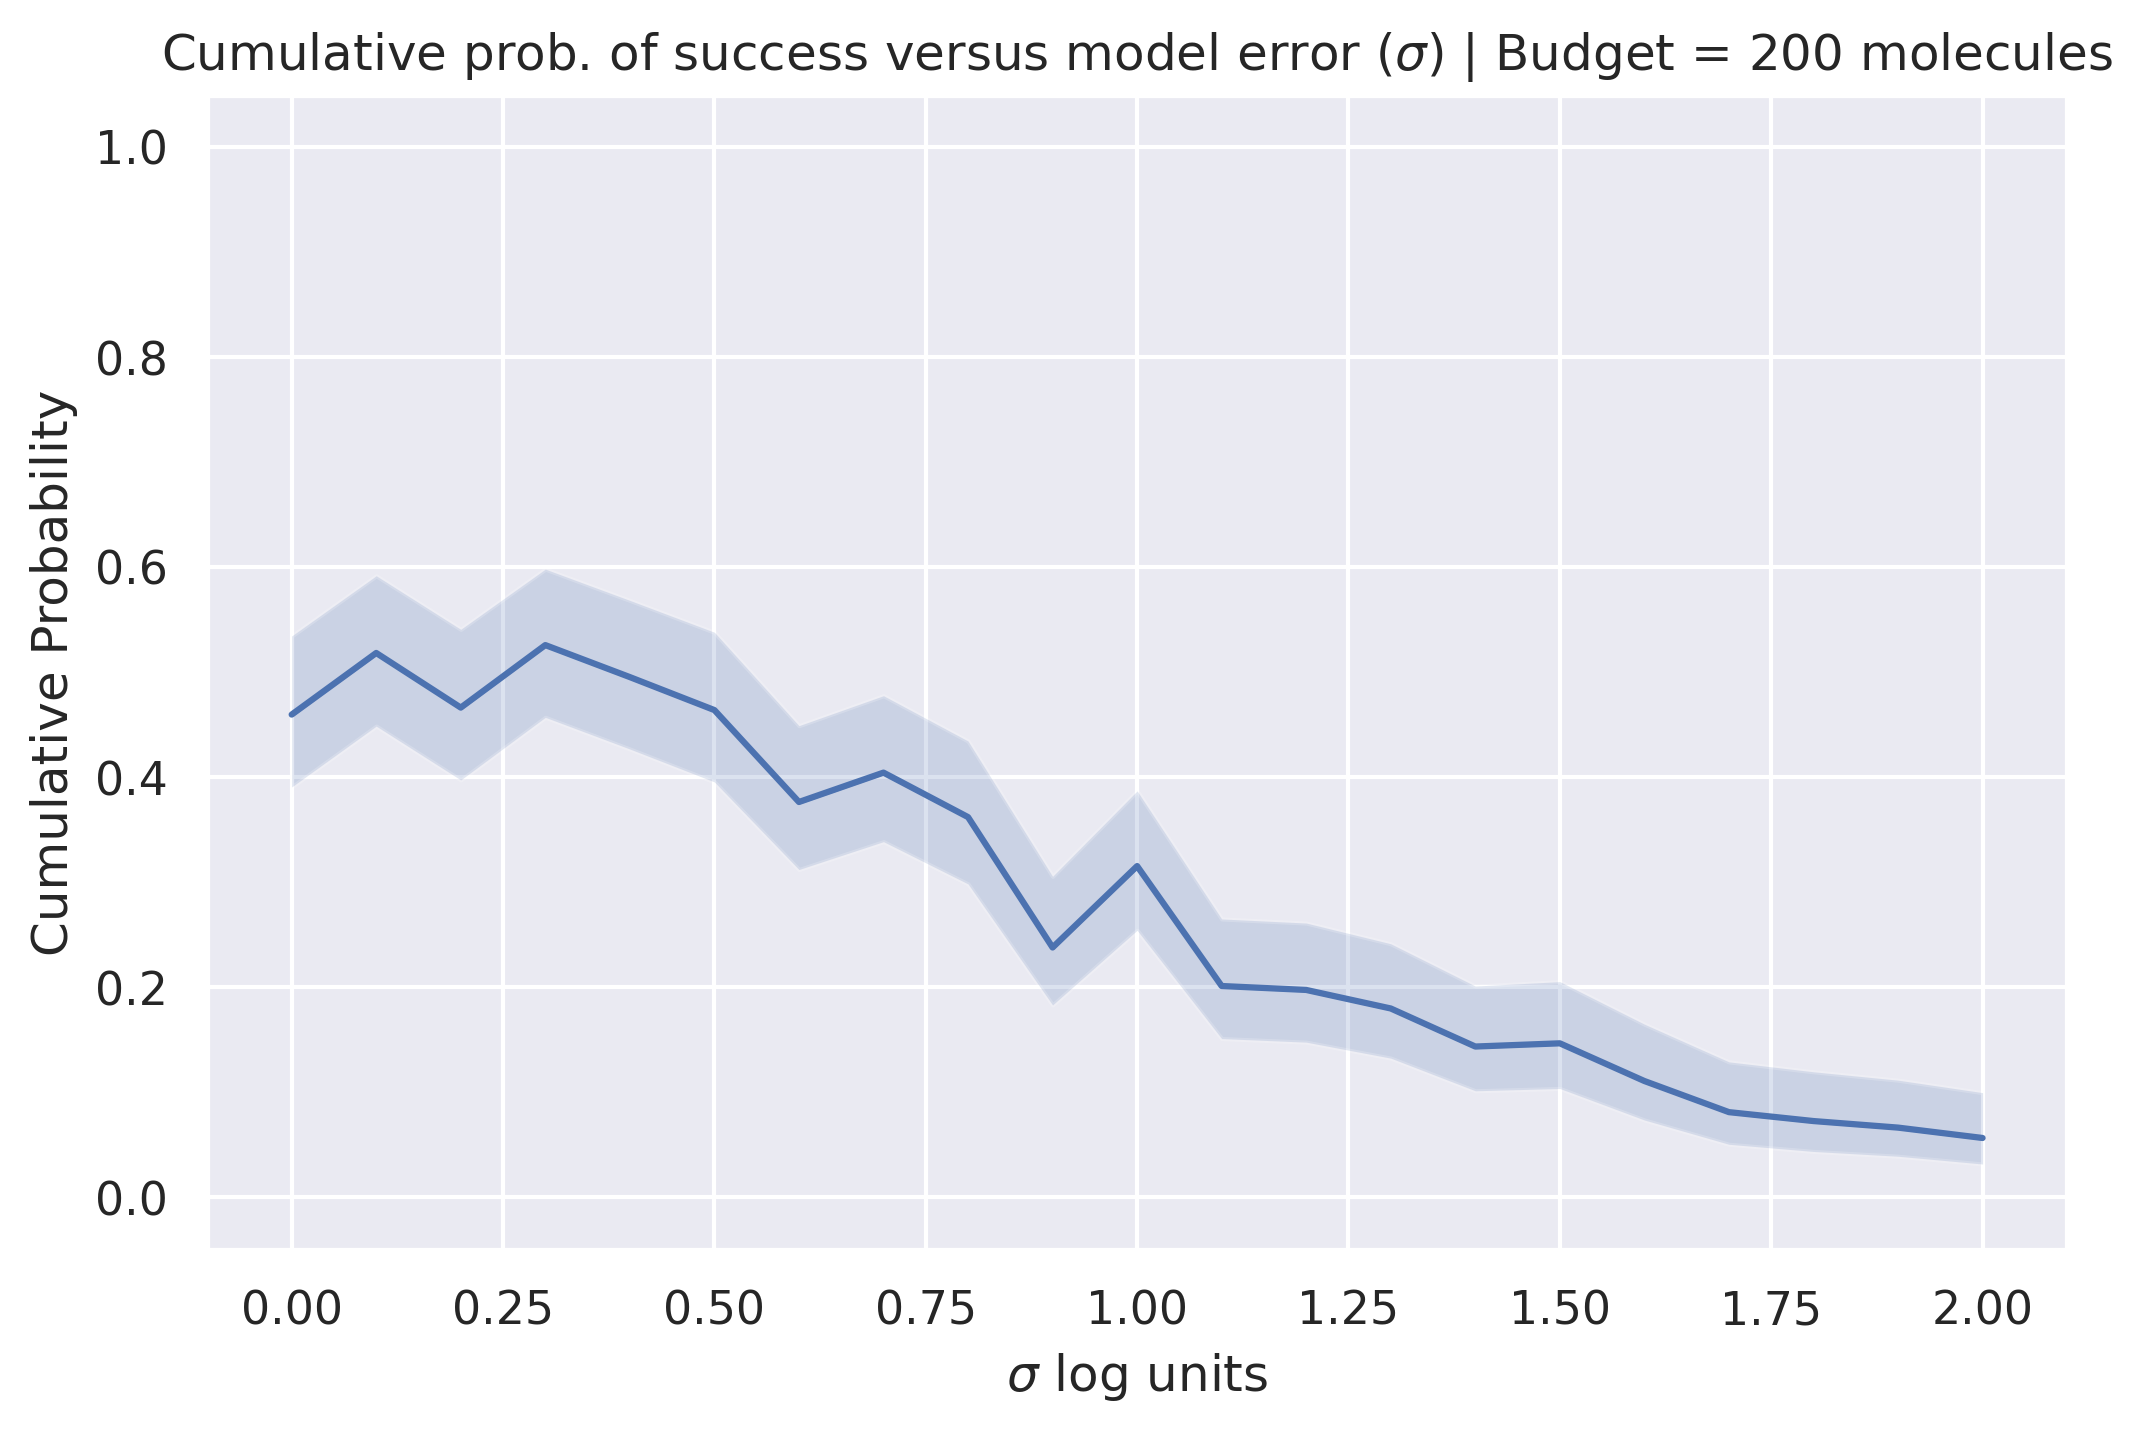

In [147]:
plt.figure(figsize=(8, 5), dpi=300)

budget = 200
filtered = ecdf.query(f'{budget} < timeline < {budget} + 5.0')
g = sns.lineplot(
    filtered,
    x='sigma',
    y='KM_estimate',
)

g.fill_between(
    filtered['sigma'],
    filtered['KM_estimate_lower_0.95'],
    filtered['KM_estimate_upper_0.95'],
    alpha=0.2,
)

plt.ylim(-0.05, 1.05)
plt.xlabel('$\sigma$ log units')
plt.ylabel('Cumulative Probability')
plt.title(f'Cumulative prob. of success versus model error ($\sigma$) | Budget = {budget} molecules')

Plotting costs.

Text(0.5, 1.0, 'Expected cost versus model error ($\\sigma$) | Probability of Success = 40.0%')

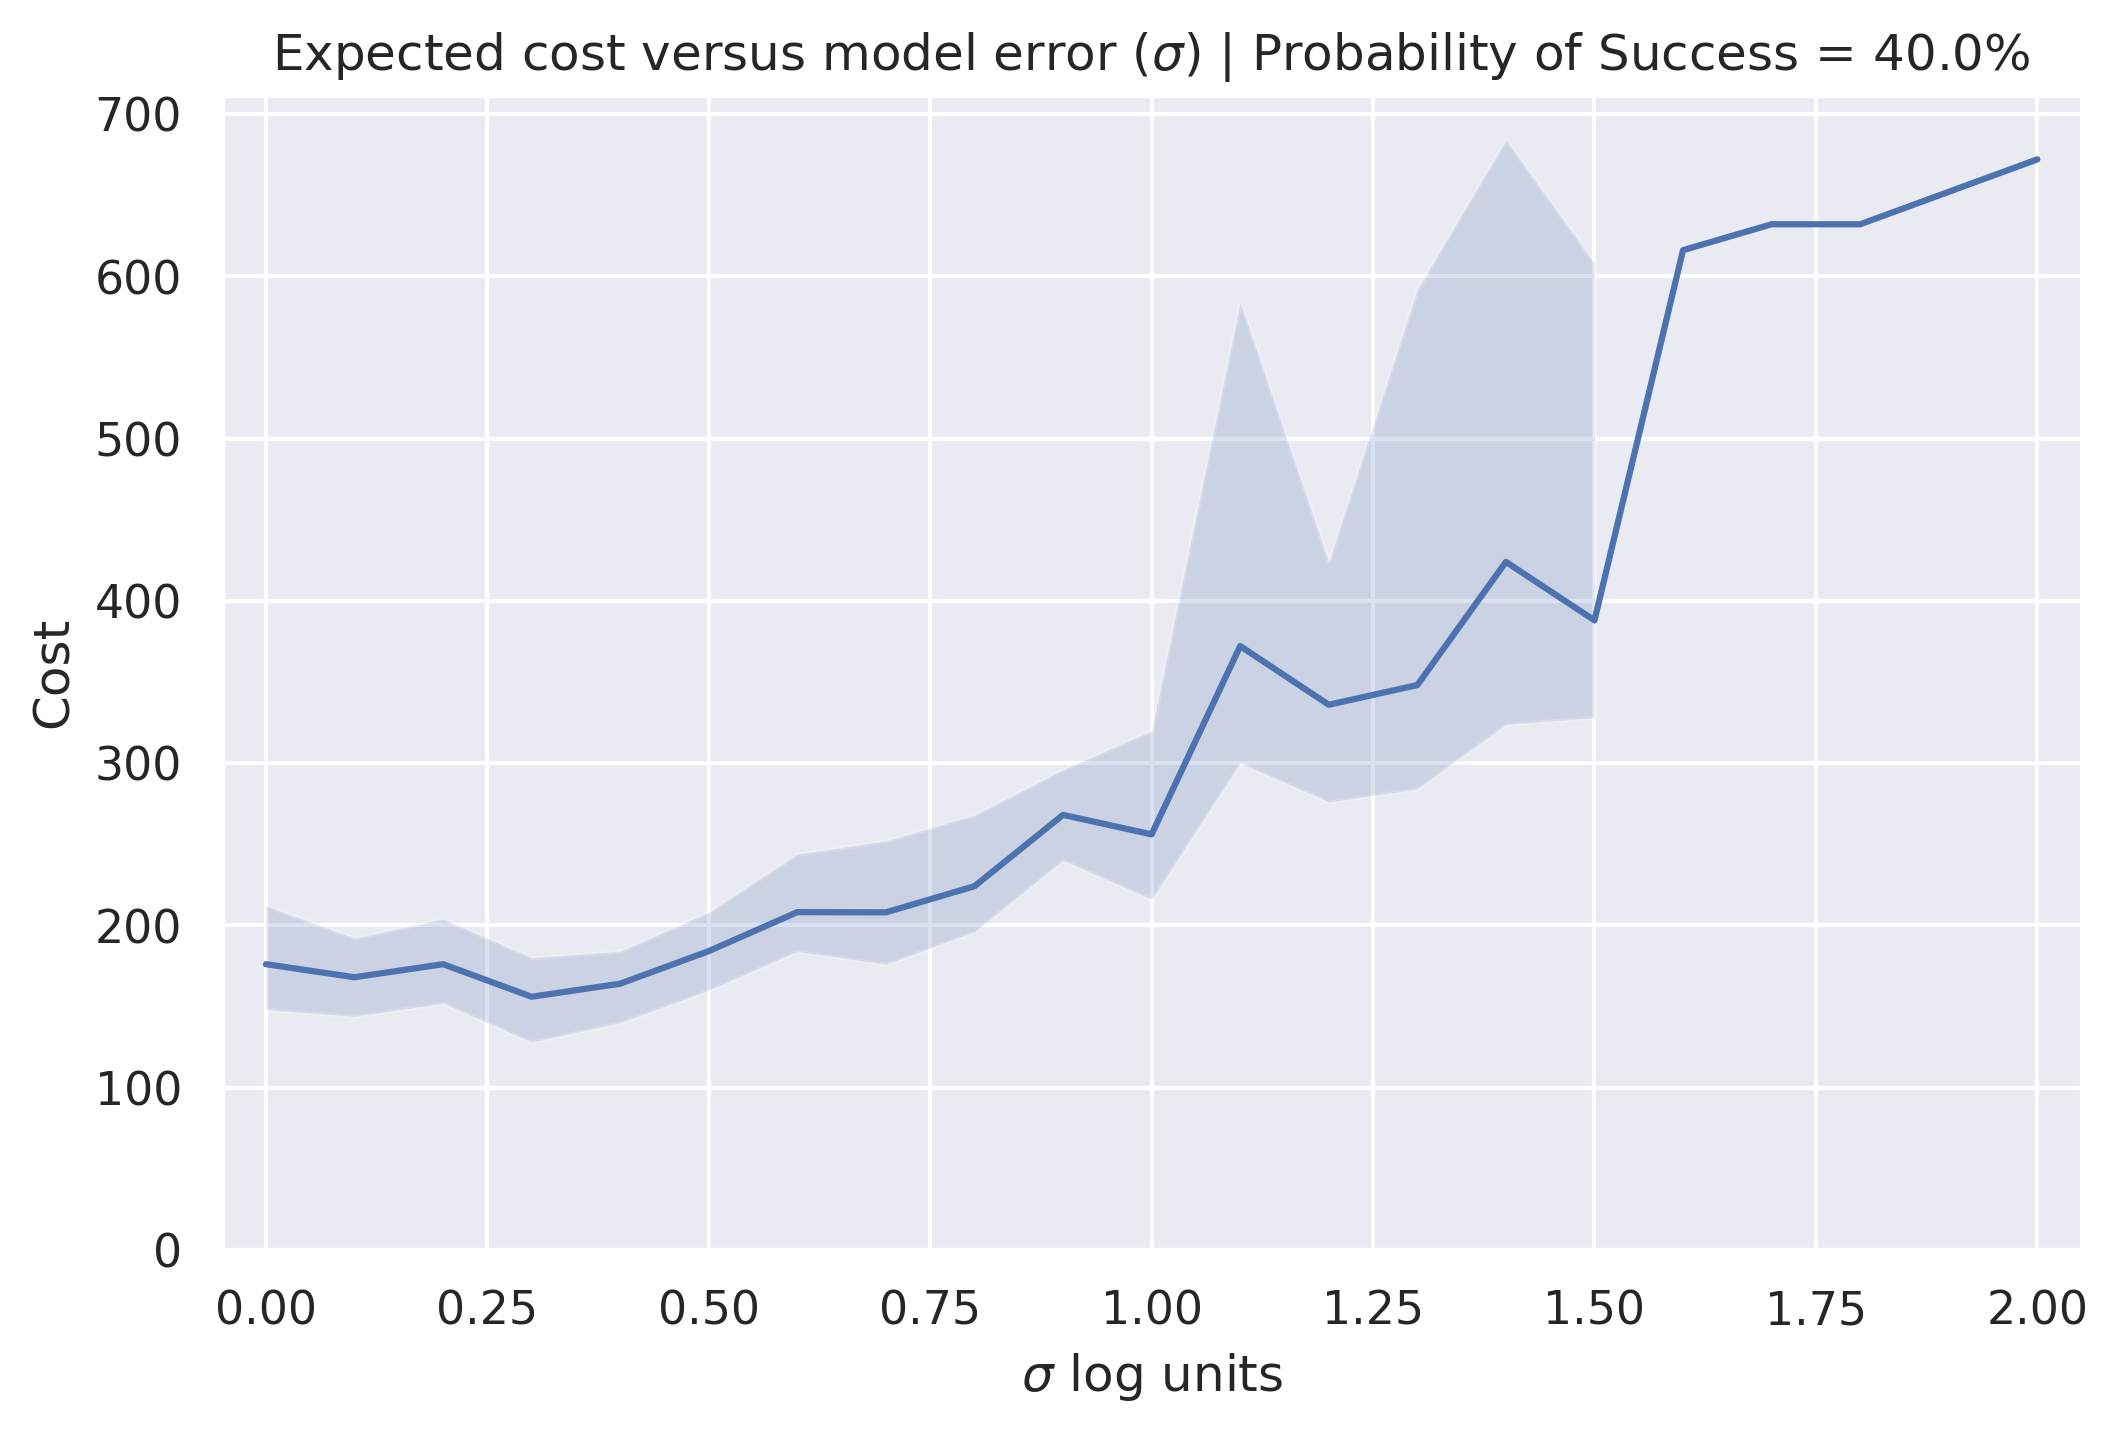

In [327]:
plt.figure(figsize=(8, 5), dpi=300)

prob_success = 0.4
filtered = ecdf.query(f'{prob_success} - 0.05 < KM_estimate < {prob_success} + 0.05')
filtered_low = ecdf.query(f'{prob_success} - 0.05 < `KM_estimate_lower_0.95` < {prob_success} + 0.05')
filtered_high = ecdf.query(f'{prob_success} - 0.05 < `KM_estimate_upper_0.95` < {prob_success} + 0.05')

filtered_mean = filtered.groupby('sigma').agg({'timeline': 'mean'})
filtered_low = filtered_low.groupby('sigma').agg({'timeline': 'mean'})
filtered_high = filtered_high.groupby('sigma').agg({'timeline': 'mean'})

g = sns.lineplot(
    filtered_mean,
    x='sigma',
    y='timeline',
)

max_ci_length = min(len(filtered_mean), len(filtered_low), len(filtered_high))
g.fill_between(
    filtered_mean.index[:max_ci_length],
    filtered_low['timeline'].iloc[:max_ci_length],
    filtered_high['timeline'].iloc[:max_ci_length],
    alpha=0.2,
)

plt.ylim(0)
plt.xlim(-0.05, 2.05)
plt.xlabel('$\sigma$ log units')
plt.ylabel('Cost')
plt.title(f'Expected cost versus model error ($\sigma$) | Probability of Success = {prob_success * 100}%')

In [391]:
df_copy = df.copy()
failed = df.query('outcome == 0').index
df_copy.loc[failed, 'cost'] = np.inf

bootstraps = []
percentile = 0.15
for sigma, df_sigma in tqdm(df_copy.groupby('sigma')):
    percentile_threshold = int(percentile * len(df_sigma))
    
    for _ in range(1000):
        # Bootstrap samples
        df_sigma_sampled = df_sigma.sample(len(df_sigma), replace=True)
        
        # Sort and cumulative sum outcomes
        df_sigma_sorted = df_sigma_sampled.sort_values('cost')
        cumulative_sum = df_sigma_sorted['outcome'].cumsum()
        percentile_index = np.where(cumulative_sum == percentile_threshold)
        
        # Find cost and add to records
        try:
            percentile_cost = df_sigma_sorted.iloc[percentile_index]['cost'].values[0]
            bootstraps.append({'sigma': sigma, 'cost': percentile_cost})
        except:
            bootstraps.append({'sigma': sigma, 'cost': np.nan})
            
bootstraps = pd.DataFrame(bootstraps)

ci_records = []
for sigma in pd.unique(bootstraps['sigma']):
    lower_ci = bootstraps.query(f'sigma == {sigma}').sort_values('cost').iloc[50]['cost']
    upper_ci = bootstraps.query(f'sigma == {sigma}').sort_values('cost').iloc[1000-50]['cost']
    ci_records.append({'sigma': sigma, 'lower': lower_ci, 'upper': upper_ci})

intervals = pd.DataFrame(ci_records)
intervals = intervals.fillna(bootstraps['cost'].max())

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Expected cost versus model error ($\\sigma$) | $P_{success}$ > 15%')

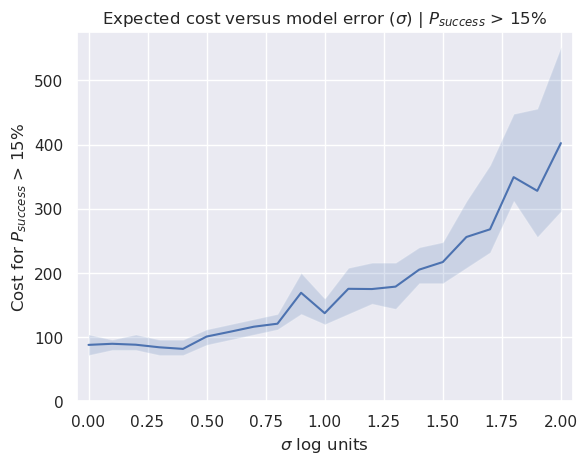

In [406]:
g = sns.lineplot(
    bootstraps,
    x='sigma', y='cost', ci=None
)

g.fill_between(
    intervals['sigma'],
    intervals['lower'],
    intervals['upper'],
    alpha=0.2,
)

plt.ylim(0)
plt.xlim(-0.05, 2.05)
plt.xlabel('$\sigma$ log units')
p_success = '$P_{success}$'
plt.ylabel(f'Cost for {p_success} > {int(percentile * 100)}%')
plt.title(f'Expected cost versus model error ($\sigma$) | {p_success} > {int(percentile * 100)}%')